In [15]:
import networkx as nx
import matplotlib as plt
import numpy as np
import pandas as pd
from itertools import permutations
import datetime

In [16]:
def randomWave(wavelist):
    random_seed=np.random.randint(len(wavelist))
    return wavelist[random_seed]


# In[8]:


def zero_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges      

def pathBand(path):
    path_len=len(path)
    #print(path)
    #print(path[0][0])
    resource=Resource[path[0][0]][path[0][1]][path[0][2]]
    for i in range(1,path_len):
        resource=list(map(lambda x: x[0]+x[1], zip(resource, Resource[path[i][0]][path[i][1]][path[i][2]])))
    pathbandList=zero_runs(resource) 
    
    return pathbandList


# In[9]:

def bypassJudge(link1,link2):
    Judge=0
    edgeLoc0=edges_list.index((link1[0],link1[1]))
    edgeLoc1=edges_list.index((link2[0],link2[1]))
                              
    if(link2 in Out_bypassEdges[edgeLoc0][link1[2]] and link1 in In_bypassEdges[edgeLoc1][link2[2]]):
        Judge=1
    return Judge
    
                              
def bypassType(path):
    bypass_type=0                
    path_len=len(path)
    #print(path_len)
    for i in range(1,path_len):
        bypass_type+=bypassJudge(path[i-1],path[i])                       
    #print(bypass_type)        
    return bypass_type
                              

                
            


# In[10]:


def pathBand_Ocuupy(loc1,loc2,wave1,band,index):
    path=SD_pathLink[loc1][loc2]
    pathBand=ALL_SD_bandwidth[loc1][loc2]
    for i in range(len(path)):
        for j in range(band):
            #print(path)
            #print(wave1)
            #print(Resource[path[i][0]][path[i][1]][path[i][2]][wave1+j])
            Resource[path[i][0]][path[i][1]][path[i][2]][wave1+j]+=index+1
            
    return

        
def pathUpdate():
    SR_bandwidth=[]
    #MaxBand=[]
    Hops=[]
    for i in range(len(SD_pathLink)):
        band=[]
        #Max=[]
        hops=[]        
        for j in range(len(SD_pathLink[i])):
            #cost.append(pathCost(SD_pathLink[i][j]))
            hops.append(len(SD_pathLink[i][j]))
            b=pathBand(SD_pathLink[i][j])
            #Max.append(max(b[:,1] - b[:,0]))
            band.append(b)            
        #SR_pathLink_cost.append(cost)
        SR_bandwidth.append(band)
        #MaxBand.append(Max)
        Hops.append(hops)
    global ALL_SD_bandwidth
    ALL_SD_bandwidth=SR_bandwidth
        
    return


# In[11]:


def CoreSetup():
    Nodes_list=list(G.nodes)
    #Link_bypass=[]
    for i in Nodes_list:
        neighborList=list(G.neighbors(i))
        #bypasscore_num=len(neighborList)-1# set the bypass core number within each fiber 
        for j in range(len(neighborList)):
            dis=1
            while(j+dis<len(neighborList)):
                input_loc=edges_list.index((neighborList[j],i))
                output_loc=edges_list.index((i,neighborList[j+dis]))
                successFlag=0
                for m in range(7):
                    if(len(bypassEdges[input_loc][m])==0):
                        for n in range(7):
                            if(len(bypassEdges[output_loc][n])==0):
                                bypassEdges[output_loc][n].append(((neighborList[j],i,m)))
                                bypassEdges[input_loc][m].append(((i,neighborList[j+dis],n)))
                                successFlag=1
                                break
                        if(successFlag==1):
                            break
                input_loc=edges_list.index((neighborList[j+dis],i))
                output_loc=edges_list.index((i,neighborList[j]))
                successFlag=0
                for m in range(7):
                    if(len(bypassEdges[input_loc][m])==0):
                        for n in range(7):
                            if(len(bypassEdges[output_loc][n])==0):
                                bypassEdges[output_loc][n].append(((neighborList[j+dis],i,m)))
                                bypassEdges[input_loc][m].append(((i,neighborList[j],n)))
                                successFlag=1
                                break
                        if(successFlag==1):
                            break
                                                                                                        
                dis+=1
    return;


# In[12]:


def edgeToLinks(path):
    pathlist=[]
    path_len=len(path)
    corePossib=7**path_len
    for i in range(corePossib):
        List=[]
        List.append((path[0]+(i%7,)))
        edgeLoc=edges_list.index(path[0])
        
        if(len(In_bypassEdges[edgeLoc][i%7])>0):
            List=[]
            continue
        for j in range(1,path_len):
            List.append((path[j]+((int(i/(7**j)%7)),)))
            edgeLoc0=edges_list.index(path[j-1])
            edgeLoc1=edges_list.index(path[j])
            if(len(Out_bypassEdges[edgeLoc0][List[j-1][2]])>0 and List[j] not in Out_bypassEdges[edgeLoc0][List[j-1][2]] ) :

                List=[]
                break
            if(len(In_bypassEdges[edgeLoc1][List[j][2]])>0 and List[j-1] not in In_bypassEdges[edgeLoc1][List[j][2]] ) :

                List=[]
                break
        edgeLoc=edges_list.index(path[path_len-1])
        if(len(Out_bypassEdges[edgeLoc][int(i/(7**(path_len-1)))])>0):            
            List=[]
            continue 
        if(len(List)>0):
            pathlist.append(List)    
    return pathlist


# In[106]:


def PathAlgorithm_1(PathList,hopsList,bandwidth,pathBandList,bypassList,list1,list2):
    Max=np.zeros(len(pathBandList))
    Sum=np.zeros(len(pathBandList))
    for i in range(len(pathBandList)):
        #print (pathBandList[i][:,1] - pathBandList[i][:,0])
        #print(i)
        #print(PathList[0])
        Max[i]=max(pathBandList[i][:,1] - pathBandList[i][:,0])
        Sum[i]=sum(pathBandList[i][:,1] - pathBandList[i][:,0])
    
    infor={"place":range(len(PathList)),
           "bypass":bypassList,
           "bandwidth": Max,
           "hops": hopsList,
           "sum":Sum
         }
    
    Path_infor=pd.DataFrame(infor)     
    #print(Path_infor)
    df=Path_infor.sort_values(by=list1,ascending=list2) 
    df.reset_index(drop=True, inplace=True)#reset the index sequence
    #print(df)
    
    Path_loc=[]
    for i in range(len(df)):
        if(df["bandwidth"][i]>bandwidth):
            Path_loc.append(df["place"][i])
    
        #print(df)
    return Path_loc


# In[107]:


def PathOccupy_percent():
    Bypass_2=[]
    Bypass_1=[]
    Bypass_0=[]
    for i in range(len(edges_list)):
        if(edges_list[i] in Traffic_SD_pairs):
            for j in range(len((SD_pathLink[i]))):
                percent=1-(sum(ALL_SD_bandwidth[i][j][:,1]-ALL_SD_bandwidth[i][j][:,0])-1)/160
                if(Bypass_Type[i][j]==2):
                    Bypass_2.append((percent))
                elif(Bypass_Type[i][j]==1):
                    Bypass_1.append((percent))
                elif(Bypass_Type[i][j]==0):
                    Bypass_0.append((percent))
    Bypass=[]
    Bypass.append(Bypass_0)
    Bypass.append(Bypass_1)
    
    Bypass.append(Bypass_2)
    
    return Bypass


# In[108]:


def Link_percentage():
    Edge=[]
    Link=[]
    for i in edges_list:
        Edge.append(str(i))
    for j in range(7):        
        occupy=[]
        for i in edges_list:
            #print(i)
            #print(list(np.nonzero(Resource[i[0]][i[1]][j])))
            k=np.array(Resource[i[0]][i[1]][j])
            per=float(np.count_nonzero(k))/160
            occupy.append(per)
        Link.append(occupy)
    df=pd.DataFrame(Link,columns=Edge)
    #print(df)
    #df.rename()
    return df
        


# In[109]:


def Path_percent():
    Bypass_2=[]
    Bypass_1=[]
    Bypass_0=[]
    for i in range(len(edges_list)):
        if(edges_list[i] in Traffic_SD_pairs):
            for j in range(len((SD_pathLink[i]))):
                #percent=1-(sum(ALL_SD_bandwidth[i][j][:,1]-ALL_SD_bandwidth[i][j][:,0])-1)/160
                if(Bypass_Type[i][j]==2):
                    Bypass_2.append((SD_pathLink[i][j]))
                elif(Bypass_Type[i][j]==1):
                    Bypass_1.append((SD_pathLink[i][j]))
                elif(Bypass_Type[i][j]==0):
                    Bypass_0.append((SD_pathLink[i][j]))
    Bypass=[]
    Bypass.append(Bypass_0)
    Bypass.append(Bypass_1)
    
    Bypass.append(Bypass_2)
    
    return Bypass



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


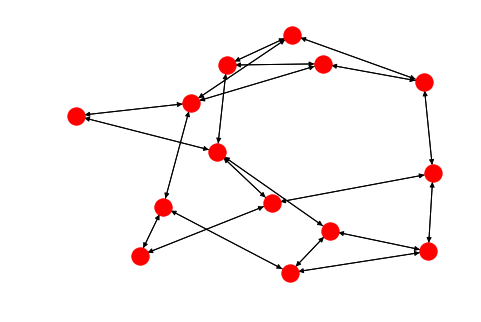

In [17]:
TrafficCost=0
node_list=list(range(14))
print(node_list)
SR_pair=list(permutations(node_list,2))

edges_list=[(0,1),(1,0),(1,2),(2,1),(0,2),(2,0),(0,3),(3,0),(3,4),(4,3),(4,5),(5,4),(2,5),(5,2),(4,6),(6,4),(3,8),(8,3),(8,11),(11,8),(9,11),(11,9),(8,13),(13,8),(9,13),(13,9),(12,13),(13,12),(11,12),(12,11),(9,10),(10,9),(5,12),(12,5),(5,10),(10,5),(7,9),(9,7),(6,7),(7,6),(1,7),(7,1)]
bypassEdges=[]
In_bypassEdges=[]
Out_bypassEdges=[]
for i in range(len(edges_list)):
    BY=[]
    BY0=[]
    BY1=[]
    
    for j in range(7):
        BY.append([])
        BY0.append([])
        BY1.append([])
    bypassEdges.append(BY)
    In_bypassEdges.append(BY0)
    Out_bypassEdges.append(BY1)
    

   
#先对D=2的节点进行bypass设置，在对D=3的节点进行bypass设置
#每次设置都在该link中不存在

G=nx.DiGraph()
G.add_nodes_from(node_list)
G.add_edges_from(edges_list)
nx.draw(G)


link_list=[] 

for k in range(len(edges_list)):
    link_list0=[]
    for i in range(7):
        link_list0.append(edges_list[k]+(i,)) 
    link_list.append(link_list0)

SD_path=[]
SR_pathLink=[]
for i in range(len(SR_pair)):
    path0=[]
    for path in nx.all_simple_paths(G, source=SR_pair[i][0], target=SR_pair[i][1]):
        path_edges=[]            
        for j in range(len(path)-1):
            path_edges.append((path[j],path[j+1]))
        if(len(path_edges)<=5):
            path0.append(path_edges)
    
    SD_path.append(path0)


CoreSetup() 

In [18]:
Max=0
for i in SD_path:
    for j in range(len(i)):
        if(Max<len(i[j])):
            Max=len(i[j])
print(Max)

5


In [19]:
for i in range(len(bypassEdges)):
    Link=bypassEdges[i]
    for j in range(7):
        if(len(Link[j])>0):
            if(Link[j][0][0]==edges_list[i][1]):
                
                Out_bypassEdges[i][j]=Link[j]
            elif(Link[j][0][1]==edges_list[i][0]):
                In_bypassEdges[i][j]=Link[j]
  
         


In [20]:
SD_pathLink=[]  
for i in range(len(SD_path)):
    Links=[]
    for j in range(len(SD_path[i])):
        Links=Links+edgeToLinks(SD_path[i][j])
    SD_pathLink.append(Links)     

In [21]:
Traffic=range(1,26)
traffic=[x*200 for x in Traffic]
Traffic_number=[1]+traffic
Success_list=[]
Tag_List=[]
True_List=[]
Traffic_length=[]
Bandwidth_list=[]
Link_status=[]
print(Traffic_number)

[1, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200, 4400, 4600, 4800, 5000]


In [ ]:
for tag_selection in range(len(Traffic_number)):
    for true_selection in range(1):
        print(tag_selection)
    
        list1=["hops","bypass","sum"]
        list2=[True, False,False]
        Traffic_num=Traffic_number[tag_selection]
        filename='traffic_'+str(Traffic_num)+'.csv'
        print(filename)
        Total_bandwidth=161
        Resource=np.zeros([14,14,7,161]).tolist()
        ALL_SD_bandwidth=[]
        MaxBand=[]
        Hops=[]
        Bypass_Type=[]
        for i in range(len(SD_pathLink)):
            Band=[]
            Max=[]
            Hhops=[]
            Bypass=[]
            for j in range(len(SD_pathLink[i])):
                Hhops.append(len(SD_pathLink[i][j]))
                b=pathBand(SD_pathLink[i][j])
                Max.append(max(b[:,1] - b[:,0]))
                Band.append(b)
                Bypass.append(bypassType(SD_pathLink[i][j]))
            ALL_SD_bandwidth.append(Band)
            MaxBand.append(Max)
            Hops.append(Hhops)
            Bypass_Type.append(Bypass)
        
        
        # In[214]:
        
        BAND=0
        
        Traffic=pd.read_csv(filename,sep=',',names=['S','D','band'])
        SuccessFlag=np.zeros(len(Traffic))
        traffic_wave=[]
        traffic_path=[]
        traffic_feedback=[]
        Traffic_num=len(Traffic)
        for i in range(Traffic_num):
            PathFlag=0
            #print(i)
            traffic=(Traffic['S'][i],Traffic['D'][i])
            band=Traffic['band'][i]
            traffic_Path=SD_pathLink[SR_pair.index(traffic)]
            traffic_Hops=Hops[SR_pair.index(traffic)]
            traffic_Band=ALL_SD_bandwidth[SR_pair.index(traffic)]
            traffic_Bypass=Bypass_Type[SR_pair.index(traffic)]
            
            selectPath_loc=PathAlgorithm_1(traffic_Path,traffic_Hops,band,traffic_Band,traffic_Bypass,list1,list2)
            #print(selectPath_loc)
            
            if(len(selectPath_loc)):
                PathFlag=0
                for j in range(len(selectPath_loc)):
                    #if(traffic_Bypass[selectPath_loc[j]]==2):
                    for empty_band in  traffic_Band[selectPath_loc[j]]:
                        if(empty_band[1]-empty_band[0]>=band):
                            select_wave=empty_band[0]
                            PathFlag=1
                            traffic_path.append(traffic_Path[selectPath_loc[j]])
                            pathBand_Ocuupy(SR_pair.index(traffic),selectPath_loc[j],select_wave,band,i)
                            SuccessFlag[i]=1
                            pathUpdate()
                            break
                    if(PathFlag==1):
                        break 
                                                
                    #else:
            

        k=0
        for i in traffic_path:
            k+=len(i)
        Traffic_length.append(k/len(traffic_path))
        
        k=0
        for i in range(Traffic_num):
            if(SuccessFlag[i]==1):
                k+=Traffic['band'][i]
        Bandwidth_list.append(k)
        Link_status.append(Link_percentage())        
        Success_list.append(SuccessFlag.sum()) 

0
traffic_1.csv


In [ ]:
print(SuccessFlag.sum())
print(Bandwidth_list)

In [ ]:
print(Link_percentage())

In [ ]:
c={'success':Success_list,
   'length': Traffic_length,
   'band':Bandwidth_list
    
}

test=pd.DataFrame(c)
test.to_csv('firstfit.csv')